In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math

import os
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from shapely.geometry import Point, Polygon
import shapely.geometry
import requests

C:\Users\revei\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data processing

In [2]:
def txt_to_dataframe(FOLDER_NAME,FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe and save it as a csv file 
    - FOLDER_NAME: name of the folder in which the txt file is
    - FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file and save it as a csv file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FOLDER_PATH = './Data/' + FOLDER_NAME
    FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".txt"
    CSV_FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".csv"
    
    if os.path.exists(CSV_FILE_PATH) == False:
        with open(FILE_PATH, 'r', encoding="utf8") as f:
    
            for line in f:
                line = line.replace(u'\xa0','')
                listedline = line.split(':',1) # split around the ":" sign
        
                # take non-empty lines
                if len(listedline) > 1:
                    newDict[listedline[0]] = listedline[1].strip()
        
                # finish the dictionary for the line
                if listedline[0] == keys_list[-1]:
                    dict_list.append(newDict)
            
                    # reinitialize the dictionary for the next line
                    newDict = {key: None for key in keys_list}
    
            # transform list of dictionaries to dataframe
            df = pd.DataFrame(dict_list,columns=keys_list)
            
            # save dataframe file to a pickle file
            df.to_csv(CSV_FILE_PATH)
    
        return df
    
    elif os.path.exists(CSV_FILE_PATH)==False:
        
        df_csv = pd.read_csv(CSV_FILE_PATH,index_col = [0])
        
        
    
        return df_csv

In [3]:
# read csv data files

keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews", keys_reviews)

In [4]:
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")
df_users_RB = pd.read_csv("./Data/RateBeer/users.csv")

In [5]:
# read brewery csv with api
df_breweries_RB = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")
df_breweries_RB.drop('Unnamed: 0.1', axis = 1, inplace = True)
df_breweries_RB.drop('Unnamed: 0', axis = 1, inplace = True)
df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

In [6]:
# merge reviews and beers on beer id
df_reviews_beers_RB=pd.merge(df_reviews_RB, df_beers_RB[['beer_id','nbr_ratings']], how="left", on=['beer_id'])

# merge reviews and users on user id
df_reviews_beers_RB=pd.merge(df_reviews_beers_RB, df_users_RB[['location','nbr_ratings', 'user_id']], how="left", on=['user_id'])

# merge reviews and breweries on brewery id
df_reviews_breweries = pd.merge(df_reviews_beers_RB, df_breweries_RB, how='left', on=['brewery_id'])

df_reviews_breweries.rename(columns={"location": "brewery_location"}, inplace=True)

df_reviews_breweries = df_reviews_breweries.drop_duplicates(subset=['beer_id','user_name','user_id'],keep = 'first')


In [7]:
# keep only keys of interest
keys_to_drop = ['appearance','aroma', 'palate', 'taste', 'text', 'date', 'user_id','user_name']
df_interest_RB= df_reviews_breweries.drop(keys_to_drop, axis=1)
df_interest_RB.rename(columns={"nbr_ratings_x": "nbr_ratings", "nbr_ratings_y": "nbr_ratings_user", "location_x" : "location_user", "location_y" : "location" }, inplace=True)
print(df_interest_RB.shape)
df_interest_RB.rename(columns={"nbr_ratings": "nbr_ratings_per_beer"}, inplace=True)

df_interest_RB.head()

#keeping only beers with more than 3 reviews
df_interest_RB_filtered = df_interest_RB[df_interest_RB.nbr_ratings_per_beer>3]
df_interest_RB_filtered

df_interest_RB_filtered['mean_rating'] = df_interest_RB_filtered.groupby(['brewery_id'])['rating'].transform("mean")
df_interest_RB_filtered['mean_style'] = df_interest_RB_filtered.groupby(['style'])['rating'].transform("mean")
df_interest_RB_filtered['mean_style_brewery'] =df_interest_RB_filtered.groupby(['style','brewery_id'])['rating'].transform("mean")
df_interest_RB_filtered['nbr_beers_ratings'] =df_interest_RB_filtered.groupby(['brewery_id'])['nbr_ratings_per_beer'].transform("count")

df_interest_RB_small = df_interest_RB_filtered[df_interest_RB_filtered.nbr_ratings_per_beer<100]


(7121987, 16)


## Heatmap of reviews over time

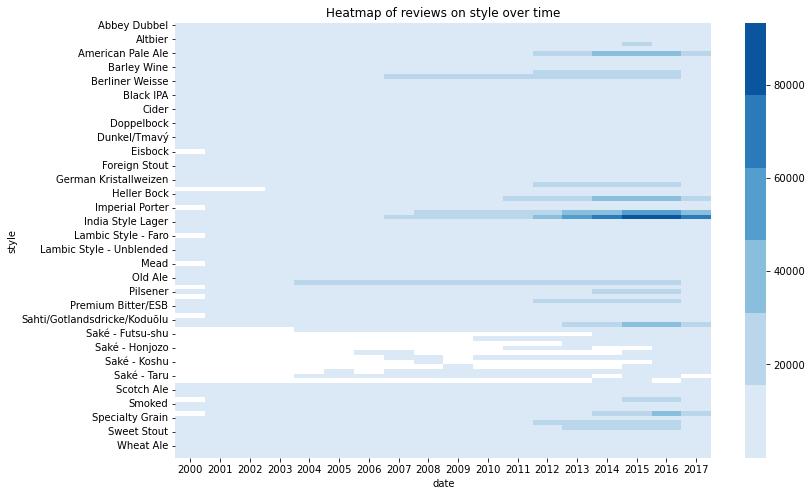

In [8]:
# Heatmap Reviews plot
import datetime

df_reviews_breweries['date'] = pd.to_datetime(df_reviews_breweries['date'], unit='s')

heatmap_reviews_time = df_reviews_breweries[["style","date"]]

pd.DatetimeIndex(heatmap_reviews_time["date"]).year
heatmap_reviews_time["date"] = pd.DatetimeIndex(heatmap_reviews_time["date"]).year

# Data to save as csv for flourish plot
#heatmap_reviews_time.to_csv("heatmap_world.csv")

heatmap_reviews_time["score"] = 1
df_interest_heatmap = heatmap_reviews_time.pivot_table(index='style',columns='date', values='score', aggfunc=lambda x: len(x))

# Figure
plt.figure(figsize=(12,8))
plt.title("Heatmap of reviews on style over time")
colormap = sns.color_palette("Blues")
sns.heatmap(df_interest_heatmap, cmap=colormap);

## Mean Rating per beer style

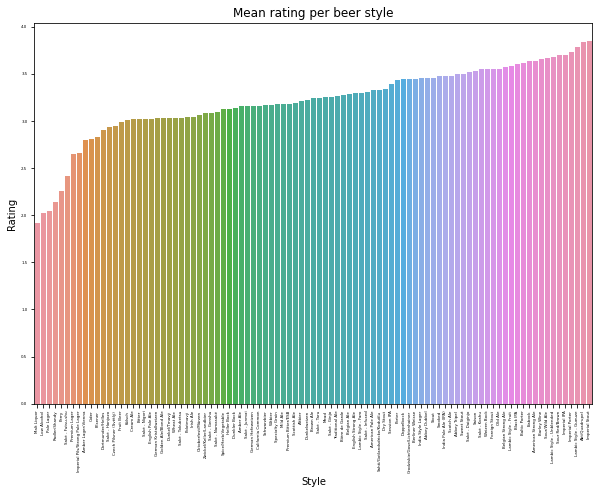

In [9]:
# Mean rating per beer style plot 

mean_style = df_reviews_breweries.groupby('style')['rating'].mean()
df_mean_style = mean_style.to_frame()
df_mean_style = df_mean_style.sort_values(by=['rating'])

# Data to save as csv for flourish plot
#df_mean_style.to_csv("ratings_style.csv")

plt.figure(figsize=(10,7))
ax = sns.barplot(x = df_mean_style.index,y='rating', data=df_mean_style)
plt.title("Mean rating per beer style")
plt.xlabel("Style")
ax.tick_params(labelsize=4)
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.show()

## Add geometry of the shapefile of the city and show global view of the breweries location

In [10]:
Lat = df_breweries_RB['latitude']
Lon = df_breweries_RB['longitude']

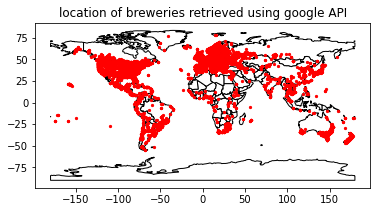

10587 breweries are inside of cities.
13598 breweries are outside of cities.


In [11]:
gdf_bre_world = gpd.GeoDataFrame(
   df_breweries_RB, geometry=gpd.points_from_xy(df_breweries_RB.longitude, df_breweries_RB.latitude))

gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


gdf_bre_world.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("location of breweries retrieved using google API")
plt.show()

# Extract the geometry of the cities dataframe we used, which contains 6018 countries
fname = "./Data/Cities.shp"

df = gpd.read_file(fname)
df = df.set_crs(epsg=4326)



# PIP test with 'within'
gdf_bre_world[gdf_bre_world['geometry'].within(df['geometry'])]   # True


num_breweries_per_city = df.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                  left_index=True, right_index=True, how="left")

num_breweries_per_city = gdf_bre_world.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                             left_index=True, right_index=True, how="left")
inp, res = df.sindex.query_bulk(gdf_bre_world.geometry, predicate='intersects')
gdf_bre_world['intersects'] = np.isin(np.arange(0, len(gdf_bre_world)), inp)
inside_city = (gdf_bre_world['intersects']==True).sum()
outside_city = (gdf_bre_world['intersects']==False).sum()

print(f'{inside_city} breweries are inside of cities.')
print(f'{outside_city} breweries are outside of cities.')

# Removing breweries that where classified in the wrong country

In [12]:
world=world.set_crs(epsg=4326, allow_override=True)
gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)
gdf_with_breweries =  gdf_bre_world.sjoin(world, how="inner", predicate='within')

In [13]:
print(f'{gdf_bre_world.shape[0] - gdf_with_breweries.shape[0]} more breweries where discared because rhey dont belong to the world shapefile.')

3402 more breweries where discared because rhey dont belong to the world shapefile.


In [14]:
inside_city = (gdf_with_breweries['intersects']==True).sum()
outside_city = (gdf_with_breweries['intersects']==False).sum()

print(f'{inside_city} breweries are inside of cities.')
print(f'{outside_city} breweries are outside of cities.')

10305 breweries are inside of cities.
10478 breweries are outside of cities.


In [15]:
#Renaming the United states to United States of America to match column name of both dataframes

contain_values = gdf_with_breweries[gdf_with_breweries['location'].str.contains('United States')]

gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('United States'), 'location'] = 'United States of America'

In [16]:
# Put Northern Ireland, Wales, England and Scotland to United Kingdom for matching reason

gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('Northern Ireland'), 'location'] = 'United Kingdom'
gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('Wales'), 'location'] = 'United Kingdom'
gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('England'), 'location'] = 'United Kingdom'
gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('Scotland'), 'location'] = 'United Kingdom'
gdf_with_breweries.shape

(20783, 14)

In [17]:
boolean = gdf_with_breweries['location'] == gdf_with_breweries['name_right']
gdf_with_breweries = gdf_with_breweries[boolean]

In [18]:
mean_rating_per_brewery = df_interest_RB_filtered.groupby('brewery_id').agg('mean')[['rating','abv']].sort_values(by='rating', ascending=False)


merged = pd.merge(gdf_with_breweries, mean_rating_per_brewery, left_on='brewery_id', right_on='brewery_id', how='left')

merged = merged.dropna(axis=0)
np.mean(merged.rating)

3.118327358584469

In [19]:
inside_city = (gdf_with_breweries['intersects']==True).sum()
outside_city = (gdf_with_breweries['intersects']==False).sum()

print(f'{inside_city} breweries are inside of cities.')
print(f'{outside_city} breweries are outside of cities.')

9689 breweries are inside of cities.
9801 breweries are outside of cities.


In [20]:
# Creating csv file to use florish to display an interactive plot on the website

df_top = df_interest_RB_filtered.loc[df_interest_RB_filtered.groupby(["brewery_id"])["mean_style_brewery"].idxmax()]

merged_top = pd.merge(gdf_with_breweries[['brewery_id','geometry','intersects','pop_est','continent']],
                      df_top, left_on='brewery_id', right_on='brewery_id', how='inner')

df_plot = merged_top[['beer_name','latitude','longitude','style','mean_rating','brewery_name','nbr_beers_ratings','nbr_beers']]

df_heatmap = df_plot
df_heatmap['mean_rating']=df_heatmap['mean_rating'].round(2)

df_heatmap['nbr_beers']=df_heatmap['nbr_beers'].astype(int)
df_heatmap['nbr_beers_ratings']=df_heatmap['nbr_beers_ratings'].astype(int)


df_heatmap['best_beer'] = df_heatmap['beer_name'] + ' (' + df_heatmap['style'] + ')'
df_heatmap= df_heatmap.drop(["beer_name", "style"],axis=1)
df_heatmap.to_csv("heatmap_world.csv")

## Distance computation to closest city center

In [21]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gd_breweries, gd_cities):

    n_breweries = np.array(list(gd_breweries.geometry.apply(lambda x: (x.x, x.y))))
    n_cities = np.array(list(gd_cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(n_cities)
    dist, idx = btree.query(n_breweries, k=1)
    gd_cities_nearest = gd_cities.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gd_breweries.reset_index(drop=True),
            gd_cities_nearest,
            pd.Series(dist, name='dist'),
        ], 
        axis=1)

    return gdf

,geometry,name,pop
0,POINT (9.93341 57.03615),Aalborg,101616.0
1,POINT (10.18027 56.16552),Aarhus,227100.0
2,POINT (7.33877 5.08421),Aba,851210.0
3,POINT (48.27875 30.34153),Abadan,260078.0
4,POINT (-48.87708 -1.72292),Abaetetuba,79420.0
...,...,...,...
6013,POINT (30.05602 -20.32500),Zvishavane,33219.0
6014,POINT (19.13998 48.57444),Zvolen,32051.0
6015,POINT (-8.13264 6.06875),Zwedru,13241.0
6016,POINT (84.26750 49.72898),Zyryanovsk,49658.0


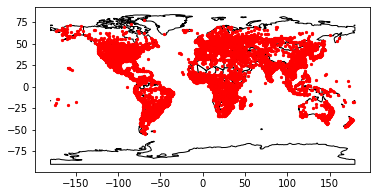

In [22]:
df_point_cities = df.to_crs(epsg=4326).centroid
gdf_point_cities = gpd.GeoDataFrame(geometry=gpd.GeoSeries(df_point_cities))
gdf_point_cities['name'] = df['name_conve']
gdf_point_cities['pop'] = df['max_pop_al']
fig, ax = plt.subplots()
world.plot(ax=ax, color='white', edgecolor='black')

gdf_point_cities.plot(ax=ax, marker='o', color='red', markersize=5)
gdf_point_cities

In [23]:
merged_bru = merged
merged = ckdnearest(merged, gdf_point_cities)

#Distance are quite short and we can approximate the earth to be a sphere to tranform it into kilometers
merged['dist_km'] = merged['dist']*math.pi/180*6371


In [24]:
#Brewery the most lost
merged[merged['dist_km']==max(merged['dist_km'])]

,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est,rating,abv,name,pop,dist,dist_km
10980,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,22,56225.0,North America,Greenland,GRL,3051,2.595238,5.3678,Narsarsuaq,145.0,16.092559,1789.410904


## Heatmap

In [25]:
# Creating csv file to use florish to display an interactive plot on the website

df_top = df_interest_RB_filtered.loc[df_interest_RB_filtered.groupby(["brewery_id"])["mean_style_brewery"].idxmax()]

merged_top = pd.merge(gdf_with_breweries[['brewery_id','geometry','intersects','pop_est','continent']],
                      df_top, left_on='brewery_id', right_on='brewery_id', how='inner')

df_plot = merged_top[['beer_name','latitude','longitude','style','mean_rating','brewery_name','nbr_beers_ratings','nbr_beers']]

df_heatmap = df_plot
df_heatmap['mean_rating']=df_heatmap['mean_rating'].round(2)

df_heatmap['nbr_beers']=df_heatmap['nbr_beers'].astype(int)
df_heatmap['nbr_beers_ratings']=df_heatmap['nbr_beers_ratings'].astype(int)


df_heatmap['best_beer'] = df_heatmap['beer_name'] + ' (' + df_heatmap['style'] + ')'
df_heatmap= df_heatmap.drop(["beer_name", "style"],axis=1)
df_heatmap.to_csv("heatmap_world.csv")

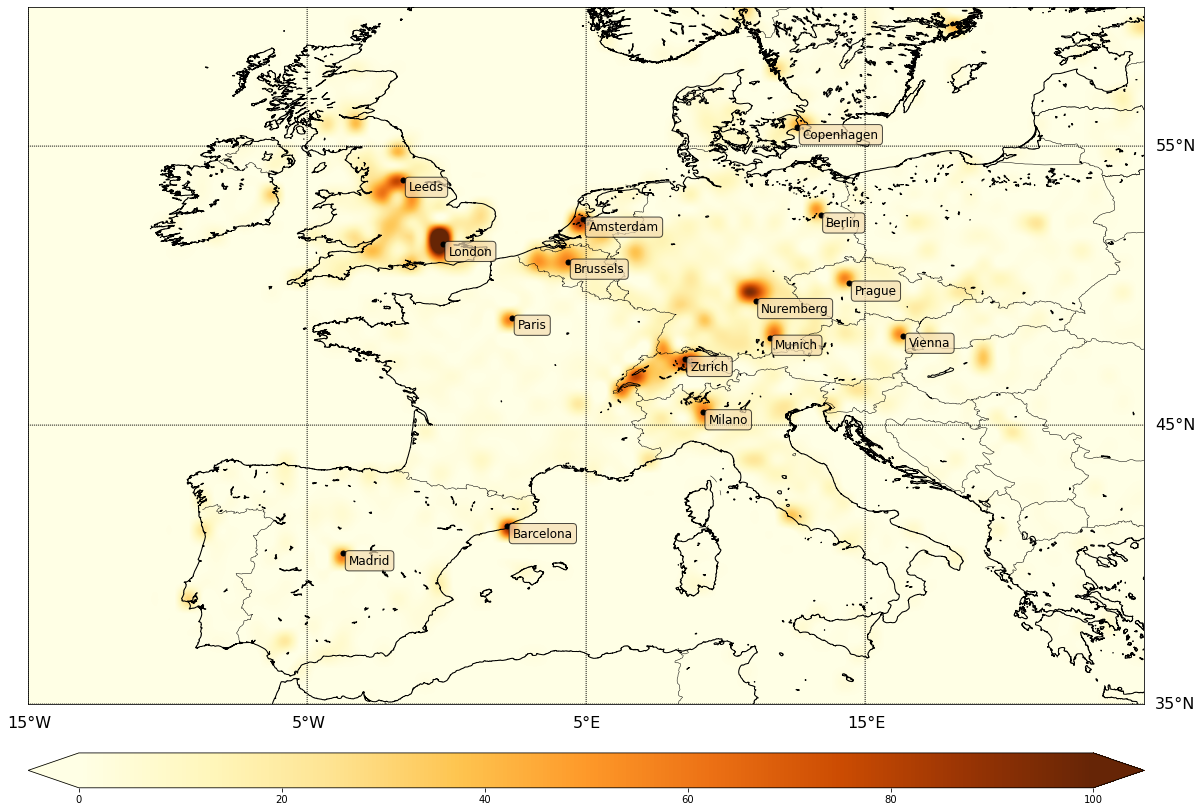

In [26]:
### PLOT DENSITY MAP FOR EUROPE

# Retrieve the latitude and longitude from the csv
df_latlng = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")
df_latlng = df_latlng.dropna()
Lon = df_latlng.longitude
Lat = df_latlng.latitude

min_lon = -15 #-15 Europe, -5 Eq test
max_lon = 25 #35 Europe, 45 Eq test
min_lat = 35 #30 Europe, -10 Eq test
max_lat = 60 #60 Europe, 10 Eq test
res = 0.5 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

fig=plt.figure(figsize=(20,15))
#map.drawmapboundary(fill_color='cornflowerblue');
#map.fillcontinents(color='white',lake_color='cornflowerblue')
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)
#map.drawrivers()

europe_cities = ['London','Madrid','Barcelona','Paris','Brussels', 'Nuremberg','Milano','Zurich', 'Munich', 'Prague',
                'Amsterdam','Leeds','Vienna','Berlin','Copenhagen']
x, y = [-0.13210273039424233, 
        -3.7039260475921756, 
        2.170203573864197,  
        2.3505167574029184, 
        4.361478258204969, 
        11.077408765587471,
        9.187737337733685,
        8.536655167071569,
        11.58159990288752,
        14.434298657641387,
        4.899544980402534,
        -1.551461638375598,
        16.371995776453147,
        13.404818927399992,
        12.567323994489191], [51.49947412249652, 
                             40.41139164037205,  
                             41.38524427503444,
                             48.853381386320294, 
                             50.86342562226807,
                             49.45118841160514,
                             45.464845014160154,
                             47.3765751027181, 
                             48.1366789972216,
                             50.07679321311305,
                             52.36955349506421, 
                             53.79752107440875,
                             48.207872846166794,
                             52.520247050584175,
                             55.684325847347885]

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=100)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
for i in range(len(x)):
    plt.plot(x[i], y[i], 'ok', markersize=5)
    plt.text(x[i]+0.2, y[i]-0.4, europe_cities[i], fontsize=12,bbox=props);


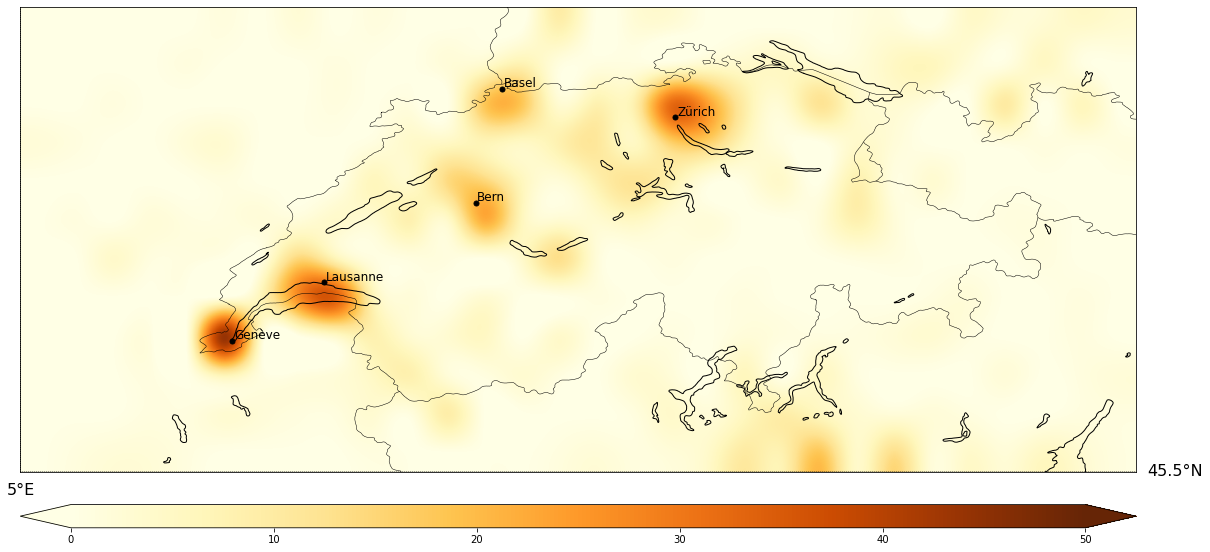

In [27]:
# PLOT DENSITY MAP FOR SWITZERLAND

min_lon = 5 #-15 Europe, -5 Eq test
max_lon = 11 #35 Europe, 45 Eq test
min_lat = 45.5 #30 Europe, -10 Eq test
max_lat = 48 #60 Europe, 10 Eq test
res = 0.2 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=50)

cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

swiss_cities = ['Lausanne','Genève','Bern','Zürich','Basel']
x, y = [6.631702927124085, 
        6.139856917862127, 
        7.447865906809013, 
        8.522236403335617, 
        7.588210720396181 ], [46.51968583011028, 
                              46.204468636535864, 
                              46.94669956363631, 
                              47.40701012873749, 
                              47.55901121385314]
for i in range(len(x)):
    plt.plot(x[i], y[i], 'ok', markersize=5)
    plt.text(x[i]+0.01, y[i]+0.01, swiss_cities[i], fontsize=12);


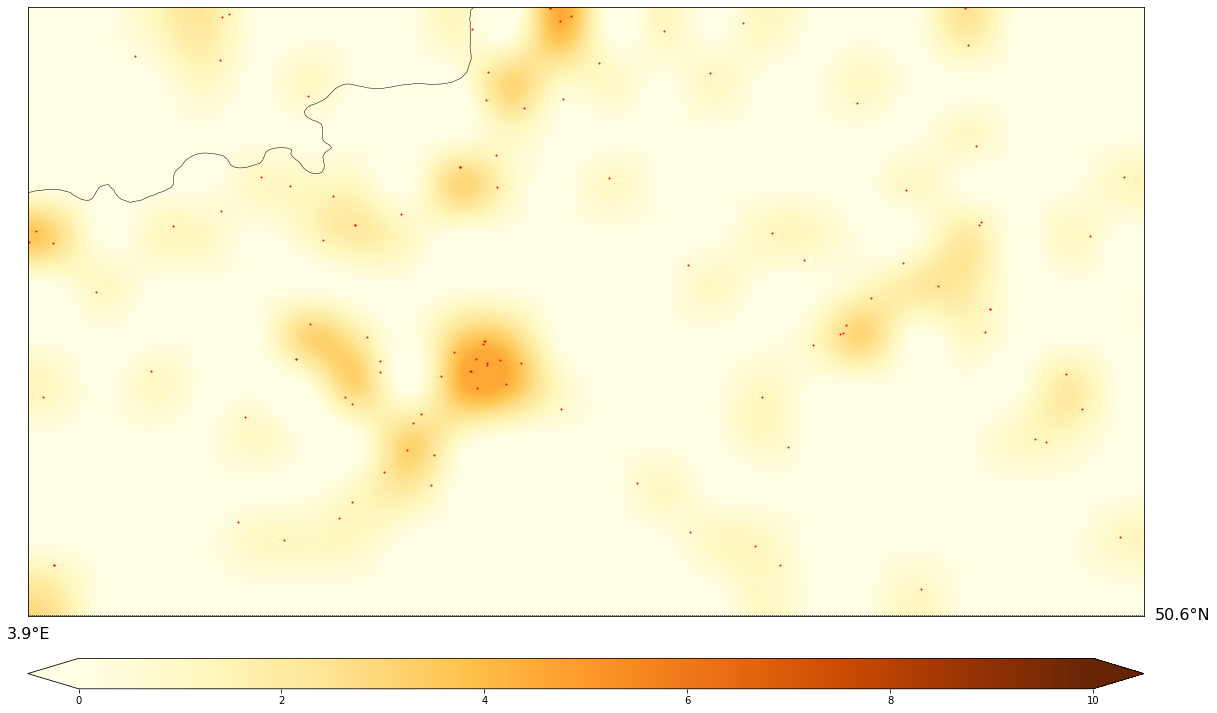

In [28]:
# BRUXEL DENSITY MAP

import jenkspy    
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


mean_rating_per_brewery_small = df_interest_RB_small.groupby('brewery_id').agg('mean')[['rating','abv']].sort_values(by='rating', ascending=False)

merged_world_small = pd.merge(gdf_with_breweries, mean_rating_per_brewery_small, left_on='brewery_id', right_on='brewery_id', how='left')

merged_world_small = merged_world_small.dropna(axis=0)



bru_point = pd.DataFrame(
    {'City': ['Brussels'],
     'Country': ['Belgium'],
     'Latitude': [50.8467595349223],
     'Longitude': [4.352345806442068]})

gdf_bru = gpd.GeoDataFrame(
    bru_point, geometry=gpd.points_from_xy(bru_point.Longitude, bru_point.Latitude))

Lat_bru =  merged_bru['latitude']
Lon_bru =  merged_bru['longitude']

min_lon = 3.9 #-15 Europe, -5 Eq test
max_lon = 5 #35 Europe, 45 Eq test
min_lat = 50.6 #30 Europe, -10 Eq test
max_lat = 51.2 #60 Europe, 10 Eq test
res = 0.05 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

density, _, _ = np.histogram2d(Lon_bru,Lat_bru,[lon_bins,lat_bins])

map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

fig=plt.figure(figsize=(20,15))
map.drawrivers()
map.drawstates()
map.drawcountries(linewidth=2)
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=10)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon_bru, Lat_bru):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

## Boxplot rating comparison ville/campagne

In [29]:
boxplot_urban = merged[merged['intersects']==True].rating
boxplot_urban = boxplot_urban.to_frame() 
boxplot_urban['Location'] = 'Urban'

boxplot_rural = merged[merged['intersects']==False].rating
boxplot_rural = boxplot_rural.to_frame() 
boxplot_rural['Location'] = 'Rural'

In [30]:
boxplot_all = pd.concat([boxplot_urban, boxplot_rural])
boxplot_all

,rating,Location
0,1.837838,Urban
2,3.383333,Urban
5,2.900000,Urban
6,2.973753,Urban
8,3.050000,Urban
...,...,...
11563,2.900000,Rural
11566,2.453017,Rural
11576,1.935227,Rural
11578,1.843902,Rural


In [31]:
medians = [boxplot_urban['rating'].median(), boxplot_rural['rating'].median()]

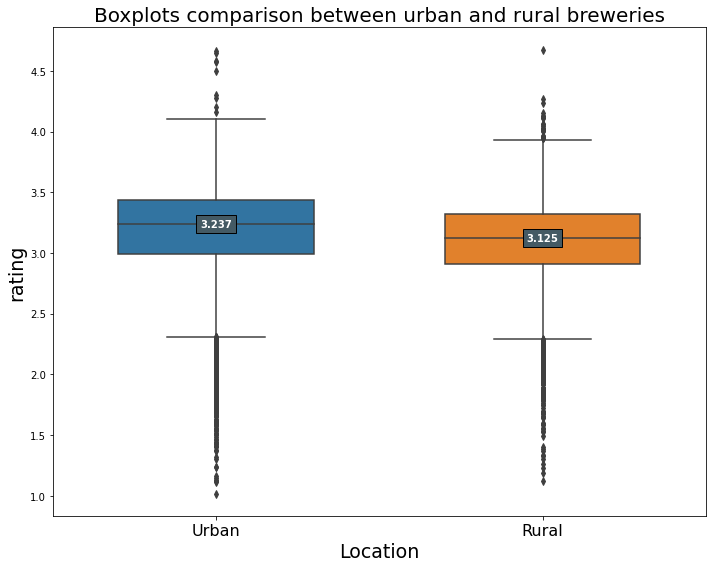

In [32]:
plt.rcParams["axes.labelsize"] = 19
plt.figure(figsize=(10,8))
plt.title('Boxplots comparison between urban and rural breweries', fontsize = 20)
box_plot = sns.boxplot(x = 'Location', y = 'rating', data=boxplot_all, width = 0.6)

ax = box_plot.axes
ax.xaxis.set_tick_params(labelsize=16)
lines = ax.get_lines()
categories = ax.get_xticks()

for i in range(2):
 
    #y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        i, 
        medians[i],
        "{:.3f}".format(medians[i]), 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()
plt.savefig('boxplots_comparison.png')

In [33]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [34]:
# define min and max boxplot values for urban and rural

lowerbound_urban ,upperbound_urban = outlier_treatment(boxplot_urban['rating'])
lowerbound_rural ,upperbound_rural = outlier_treatment(boxplot_rural['rating'])

In [35]:
outliers_urban = boxplot_urban[(boxplot_urban['rating'] < lowerbound_urban) | (boxplot_urban['rating'] > upperbound_urban)]
outliers_rural = boxplot_rural[(boxplot_rural['rating'] < lowerbound_rural) | (boxplot_rural['rating'] > upperbound_rural)]

In [36]:
outliers_rural

,rating,Location
62,1.883333,Rural
70,2.215385,Rural
101,2.200000,Rural
399,1.844444,Rural
415,2.175000,Rural
...,...,...
11529,2.129630,Rural
11535,1.529487,Rural
11576,1.935227,Rural
11578,1.843902,Rural


In [37]:
print(boxplot_urban.drop(outliers_urban.index).mean())
print(boxplot_rural.drop(outliers_rural.index).mean())

rating    3.23177
dtype: float64
rating    3.125969
dtype: float64


In [38]:
print(outliers_rural[outliers_rural.rating < lowerbound_rural].shape[0] / outliers_rural.shape[0])
print(outliers_urban[outliers_urban.rating < lowerbound_urban].shape[0] / outliers_urban.shape[0])

0.90625
0.9764397905759162


Most of the outliers are found under the boxplot whiskers (90% for rural and 97% for urban). That means that the vast majority of the outliers are bad breweries.

In [39]:
#Count outliers

urban_percentile = [np.percentile(boxplot_all[boxplot_all.Location == 'Urban']['rating'], [25])[0], np.percentile(boxplot_all[boxplot_all.Location == 'Urban']['rating'], [75])[0]]
rural_percentile = [np.percentile(boxplot_all[boxplot_all.Location == 'Rural']['rating'], [25])[0], np.percentile(boxplot_all[boxplot_all.Location == 'Rural']['rating'], [75])[0]]

mask_urban = boxplot_all[boxplot_all.Location == 'Urban']['rating'].between(urban_percentile[0], urban_percentile[1])
mask_rural = boxplot_all[boxplot_all.Location == 'Rural']['rating'].between(rural_percentile[0], rural_percentile[1])

outliers_urban = boxplot_all[boxplot_all.Location == 'Urban'][~mask_urban].shape[0]/boxplot_all[boxplot_all.Location == 'Urban'].shape[0]
outliers_rural = boxplot_all[boxplot_all.Location == 'Rural'][~mask_rural].shape[0]/boxplot_all[boxplot_all.Location == 'Rural'].shape[0]

## Linear-regression rating ville/campagne en fonction de la distance

In [40]:
features_city_campaign = pd.merge(df_interest_RB, merged[['brewery_id','intersects','dist_km']], how="left", on=['brewery_id'])
features_city_campaign = features_city_campaign.dropna()
features_city_campaign.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,overall,rating,nbr_ratings_per_beer,location_user,nbr_ratings_user,location,name,nbr_beers,latitude,longitude,intersects,dist_km
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,8,2.0,1,Poland,1890.0,Gabon,Sobraga,3.0,0.303409,9.501448,True,10.680465
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,8,1.9,10,Spain,89.0,Gabon,Sobraga,3.0,0.303409,9.501448,True,10.680465
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.6,10,Poland,169.0,Gabon,Sobraga,3.0,0.303409,9.501448,True,10.680465
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.5,10,Spain,3371.0,Gabon,Sobraga,3.0,0.303409,9.501448,True,10.680465
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,7,1.9,10,Germany,13043.0,Gabon,Sobraga,3.0,0.303409,9.501448,True,10.680465


In [41]:
np.mean(features_city_campaign[features_city_campaign.dist_km < 500]['rating'])

3.3003709103528354

In [42]:
dist_centre_rural = np.mean(merged[merged['intersects'] == False]['dist_km'])
dist_centre_city = np.mean(merged[merged['intersects'] == True]['dist_km'])

In [43]:
print(dist_centre_rural)
print(dist_centre_city)

44.59718254431282
10.390787946867851


In [44]:
from sklearn.linear_model import LinearRegression

# Performing linear regression on city data

features_columns = ['dist_km']


lin_reg = LinearRegression()

X = merged[(merged.dist_km < 500)][features_columns]
y = merged[(merged.dist_km < 500)].rating


dist_min = merged[merged.dist_km < 500][features_columns].min()
dist_max = merged[merged.dist_km < 500][features_columns].max()

#standardization

lin_reg.fit(X, y)

LinearRegression()

In [45]:
print(lin_reg.intercept_)
print(lin_reg.coef_[0])

3.1463719038556555
-0.001026885021030352


In [46]:
a1 = lin_reg.coef_[0]*dist_min + lin_reg.intercept_
print(a1)
a2 = lin_reg.coef_[0]*dist_max + lin_reg.intercept_
print(a2)

dist_km    3.146328
dtype: float64
dist_km    2.875594
dtype: float64


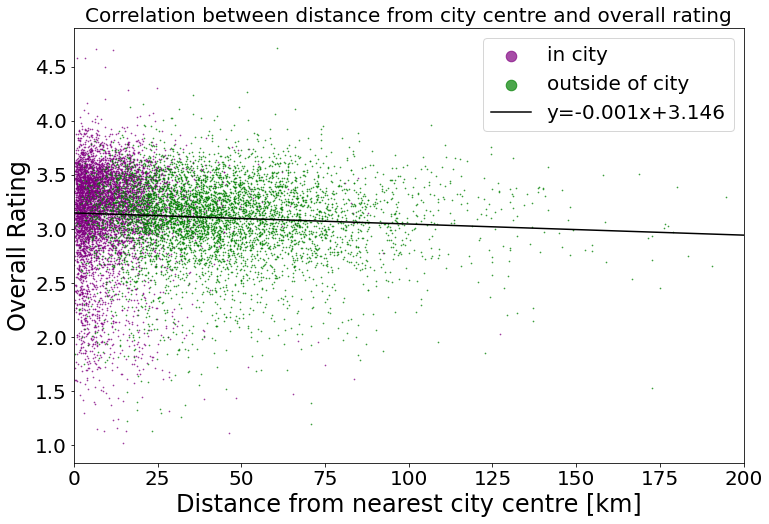

In [47]:
# Display the linear regression for distance to closest city centre

plt.figure(figsize=(12,8))
plt.title('Correlation between distance from city centre and overall rating', size=20)
plt.xlabel('Distance from nearest city centre [km]', fontsize=24)
plt.ylabel('Overall Rating', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0,200])
plt.scatter(merged[(merged.dist_km < 500)&(merged['intersects']==True)].dist_km, merged[(merged.dist_km < 500)&(merged['intersects']==True)].rating, s=.5, alpha=.7, color='purple', label = 'in city')
plt.scatter(merged[(merged.dist_km < 500)&(merged['intersects']==False)].dist_km, merged[(merged.dist_km < 500)&(merged['intersects']==False)].rating, s=.5, alpha=.7, color='green', label = 'outside of city')
plt.plot([dist_min,dist_max],[a1,a2], 'k-', label='y={:.3f}x+{:.3f}'.format(lin_reg.coef_[0], lin_reg.intercept_))
plt.legend(prop={'size': 20}, markerscale=15)
plt.savefig('Correlation_city_center_rating.png')
plt.show()

## Barplot to search for confounders

In [48]:
df_final = pd.merge(df_interest_RB_filtered, merged[['brewery_id','intersects','pop_est','continent','gdp_md_est','name', 'pop','dist_km']], how="left", on=['brewery_id'])
df_final.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,overall,rating,nbr_ratings_per_beer,location_user,...,mean_style,mean_style_brewery,nbr_beers_ratings,intersects,pop_est,continent,gdp_md_est,name_y,pop,dist_km
0,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,8,1.9,10,Spain,...,2.039916,1.837838,37,True,2172579.0,Africa,16874.0,Libreville,483355.0,10.680465
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.6,10,Poland,...,2.039916,1.837838,37,True,2172579.0,Africa,16874.0,Libreville,483355.0,10.680465
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.5,10,Spain,...,2.039916,1.837838,37,True,2172579.0,Africa,16874.0,Libreville,483355.0,10.680465


In [49]:
df_final.loc[df_final['location_user'].str.contains('Northern Ireland', na=False), 'location_user'] = 'United Kingdom'
df_final.loc[df_final['location_user'].str.contains('Wales', na=False), 'location_user'] = 'United Kingdom'
df_final.loc[df_final['location_user'].str.contains('England', na=False), 'location_user'] = 'United Kingdom'
df_final.loc[df_final['location_user'].str.contains('Scotland', na=False), 'location'] = 'United Kingdom'
df_final.loc[df_final['location_user'].str.contains('United States', na=False), 'location_user'] = 'United States of America'

In [50]:
df_final['Counts'] = df_final.groupby(['location_user'])['location_user'].transform('count')
df_final['User_count'] = df_final.groupby(['location_user', 'intersects'])['location_user'].transform('count')

In [51]:
# Keeping breweries that have the most reviews sum grouped by user location
df_final = df_final[df_final.Counts>300000]
df_num_ratings = df_final.groupby(['location_user', 'intersects']).agg("size").to_frame()
df = df_final.groupby(['location_user', 'intersects']).rating.agg("mean").to_frame()
df = df.merge(df_num_ratings, left_index=True, right_on=['location_user', 'intersects'])
df = df.rename(columns={0: "num_ratings"})

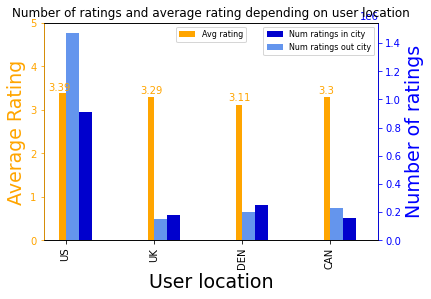

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()


width=0.07
width2=0.3

ax3 = df.rating.unstack().mean(axis=1).plot(kind = 'bar', color = ['orange'], ax =ax, width = width, position = 0)
df.num_ratings.unstack().plot(kind = 'bar' ,color = ['mediumblue','cornflowerblue'], ax =ax2, width = width2, position = 1)

plt.title('Number of ratings and average rating depending on user location')

ax.set_ylim([0,5])
ax.set_ylabel('Average Rating')
ax2.set_ylabel('Number of ratings')

ax3.set(xticklabels=['CAN','DEN','UK','US'])
ax.legend(['Avg rating'], loc='upper center', prop={'size': 8})
ax2.legend(['Num ratings in city', 'Num ratings out city'], loc='upper right', prop={'size': 8})

ax.yaxis.label.set_color('orange')
ax.set_xlabel('User location')
ax2.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='orange')
ax2.tick_params(axis='y', colors='blue')
ax2.spines['left'].set_color('orange')
ax2.spines['right'].set_color('blue')
plt.text(3.2,1060000, '3.39', color = 'orange')
plt.text(2.15,1040000, '3.29', color = 'orange')
plt.text(1.15,990000, '3.11', color = 'orange')
plt.text(0.13,1040000, '3.3', color = 'orange')
ax.invert_xaxis()

plt.savefig("plot_cofounder.png", dpi=150, bbox_inches='tight')
plt.show()


## Analysis on styles

In [53]:
df_top = df_interest_RB_filtered.loc[df_interest_RB_filtered.groupby(["brewery_id"])["mean_style_brewery"].idxmax()]

In [54]:
merged_top = pd.merge(gdf_with_breweries[['brewery_id','geometry','intersects','pop_est','continent']],
                      df_top, left_on='brewery_id', right_on='brewery_id', how='inner')

In [81]:
grouped1= merged_top[merged_top['intersects'] == True]
grouped2= merged_top[merged_top['intersects'] == False]
gr1= grouped1['style'].value_counts().to_frame()
gr2=grouped2['style'].value_counts().to_frame()
group_beers = pd.merge(gr1, gr2, left_index=True, right_index=True)
group_beers=group_beers.rename(columns={"style_x": "Number of breweries with that favorite style inside the city",
                            "style_y": "Number of breweries with that favorite style ouside of the city"})

Sum_in_city = group_beers['Number of breweries with that favorite style inside the city'].sum()
Sum_out_city= group_beers['Number of breweries with that favorite style ouside of the city'].sum()
print(f' There are {Sum_in_city} inside of the city')
print(f' There are {Sum_out_city} outside of the city')

group_beers['ratio_in'] = group_beers['Number of breweries with that favorite style inside the city']/Sum_in_city*100

group_beers['ratio_out'] = group_beers['Number of breweries with that favorite style ouside of the city']/Sum_out_city*100
plot_beers=group_beers

plot_beers2 = plot_beers.sort_values(by="ratio_out", ascending=False)

 There are 5966 inside of the city
 There are 5970 outside of the city


<Figure size 2520x1260 with 0 Axes>

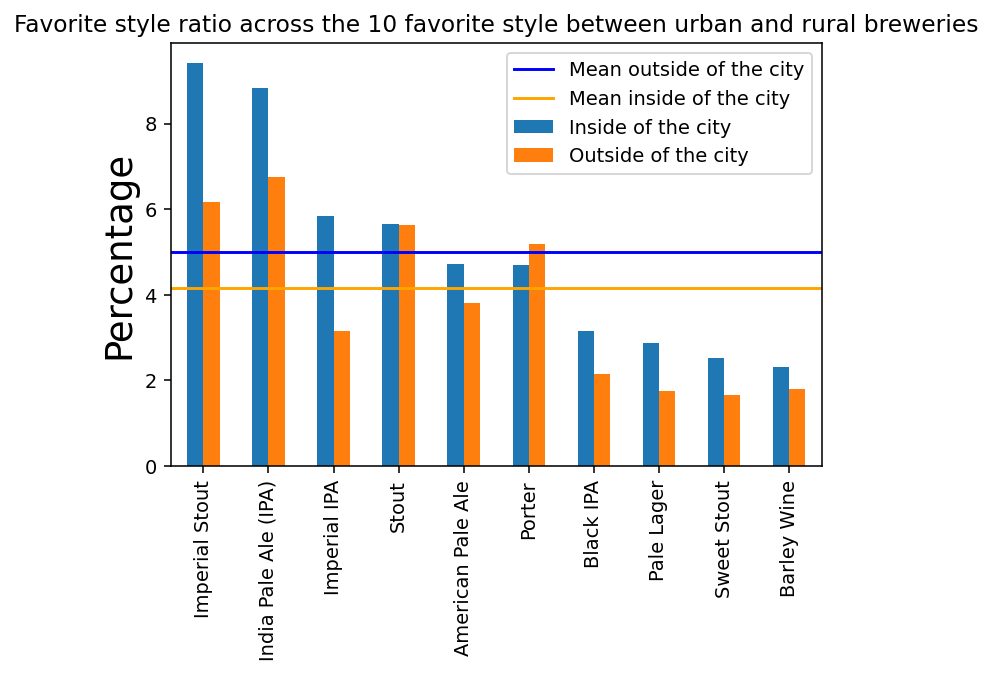

In [84]:
plot_beers_10 = plot_beers.head(10)
plot_beers_10_b = plot_beers2.head(10)

mean_in = plot_beers_10['ratio_in'].mean()
mean_out = plot_beers_10_b['ratio_out'].mean()

plt.figure(figsize=[18,9])
plt.rcParams['figure.dpi']=140
ax = plot_beers_10.plot(y=["ratio_in", "ratio_out"], kind="bar", rot=90)

plt.title('Favorite style ratio across the 10 favorite style between urban and rural breweries')


ax.set_ylabel('Percentage')

plt.axhline(y = mean_in, label = 'Arithmetic mean',color = "blue")
plt.axhline(y = mean_out, label = 'Arithmetic mean', color="orange")
ax.legend(['Mean outside of the city', 'Mean inside of the city','Inside of the city', 'Outside of the city'], loc='upper right')


plt.savefig("Fav_style.png", dpi=150, bbox_inches='tight')

plt.show()

In [57]:
plot_beers['difference'] = plot_beers['ratio_in'] / plot_beers['ratio_out']
plot_beers = plot_beers.sort_values(by="difference", ascending=False)

for i in range(len(plot_beers)):
    if (plot_beers.difference[i]<1):
        plot_beers.difference[i] = ((-1/plot_beers.difference[i])+1)*100
    else:
        plot_beers.difference[i] = ((plot_beers.difference[i])-1)*100
        

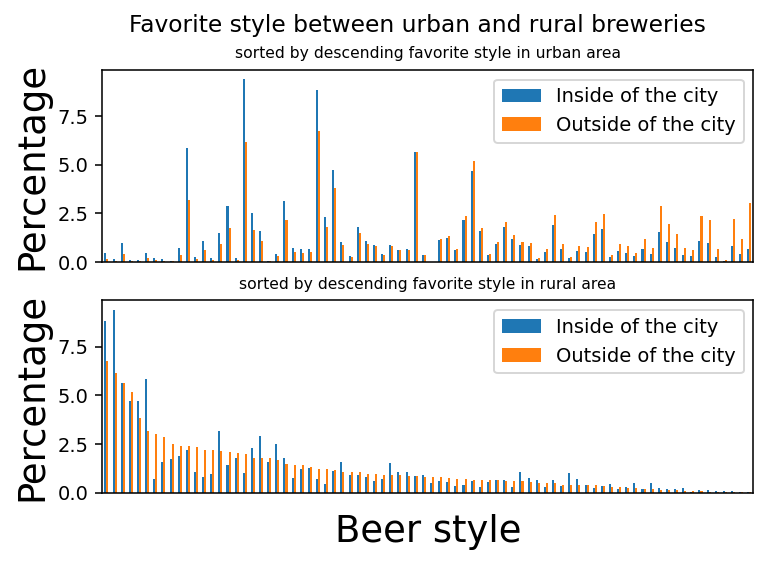

<Figure size 2520x1260 with 0 Axes>

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Favorite style between urban and rural breweries')

plt.figure(figsize=[18,9])
plt.rcParams['figure.dpi']=140

plot_beers.plot(ax=ax1,y=["ratio_in", "ratio_out"], kind="bar", rot=90)
plot_beers2.plot(ax=ax2,y=["ratio_in", "ratio_out"], kind="bar", rot=90)

#plt.title('Favorite style ratio across the 10 favorite style between urban and rural breweries')

ax1.set_title('sorted by descending favorite style in urban area',fontsize=8)
ax2.set_title('sorted by descending favorite style in rural area',fontsize=8)
ax1.set_ylabel('Percentage')
ax2.set_ylabel('Percentage')
ax1.legend(['Inside of the city', 'Outside of the city'], loc='upper right')
ax2.legend(['Inside of the city', 'Outside of the city'], loc='upper right')
ax1.set(xticklabels=[])
ax1.tick_params(bottom=False)
ax2.set(xticklabels=[])
ax2.tick_params(bottom=False)
ax2.set_xlabel('Beer style')




plt.savefig("Fav_style.png", dpi=150, bbox_inches='tight')

plt.show()

In [59]:
# Keep only styles with a higher ratio than 0.5% and styles that have more than 50% difference between themselves
plot_beers = plot_beers[(plot_beers['ratio_in'] > 0.5) & (plot_beers['ratio_out'] > 0.5)]
plot_beers = plot_beers[(plot_beers['difference'] > 50) | (plot_beers['difference'] < -50)]
table_diff_beers = plot_beers[plot_beers['ratio_out'] > 1.5*plot_beers['ratio_in']]
table_diff_beers2 = plot_beers[plot_beers['ratio_in'] > 1.5*plot_beers['ratio_out']]
table_diff_beers = table_diff_beers.append(table_diff_beers2, ignore_index=False)
plot_diff = table_diff_beers[(table_diff_beers['ratio_in']>1) | (table_diff_beers['ratio_in']>1)].sort_values(by="Number of breweries with that favorite style inside the city", ascending=False)
colors = ["royalblue", "royalblue", "royalblue", "royalblue", "royalblue","royalblue", "royalblue", "darkorange", "darkorange",
          "darkorange", "darkorange", "darkorange", "darkorange", "darkorange", "darkorange", "darkorange", "darkorange",
          "darkorange", "darkorange","darkorange"]

Text(0.5, 1.0, 'Average difference between urban and rural beer styles')

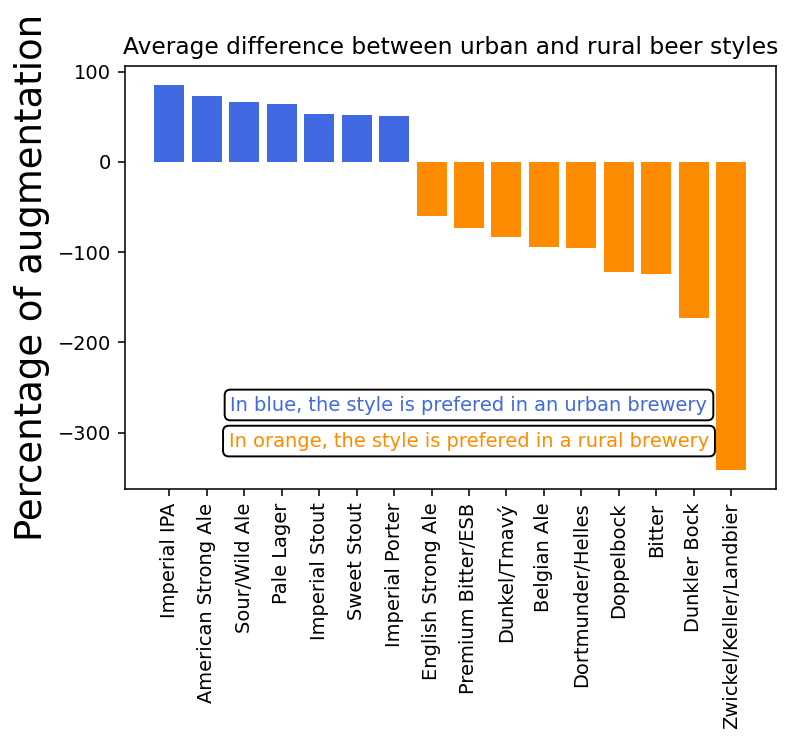

In [60]:
fig, ax= plt.subplots()
ax.bar(x=plot_beers.index,height=plot_beers.difference, color=colors)

ax.text(8, -280, 'In blue, the style is prefered in an urban brewery', ha='center', va='bottom', color="royalblue", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax.text(8, -320, 'In orange, the style is prefered in a rural brewery', ha='center', va='bottom', color="darkorange", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.xticks(rotation='vertical');
plt.ylabel("Percentage of augmentation")
plt.title("Average difference between urban and rural beer styles")

## Analysis on Brussels

In [61]:
bru_point = pd.DataFrame(
    {'City': ['Brussels'],
     'Country': ['Belgium'],
     'Latitude': [50.8467595349223],
     'Longitude': [4.352345806442068]})

gdf_bru = gpd.GeoDataFrame(
    bru_point, geometry=gpd.points_from_xy(bru_point.Longitude, bru_point.Latitude))


In [62]:
merged_bru = ckdnearest(merged_world_small,gdf_bru)

merged_bru['dist_km'] = merged_bru['dist']*math.pi/180*6371
merged_bru = merged_bru[merged_bru.dist_km <= 50]
merged_bru.head()

,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,index_right,pop_est,...,iso_a3,gdp_md_est,rating,abv,City,Country,Latitude,Longitude,dist,dist_km
9646,23249,Belgium,4Pajot,11,50.808930,4.220009,POINT (4.22001 50.80893),True,129,11484055.0,...,BEL,533097,3.136709,7.303797,Brussels,Belgium,50.84676,4.352346,0.137637,15.304563
9648,25716,Belgium,ASBL Notios,1,50.851621,4.365613,POINT (4.36561 50.85162),True,129,11484055.0,...,BEL,533097,2.739655,4.800000,Brussels,Belgium,50.84676,4.352346,0.014129,1.571095
9651,28330,Belgium,Basanina,6,50.967259,3.925175,POINT (3.92518 50.96726),False,129,11484055.0,...,BEL,533097,3.251220,8.170732,Brussels,Belgium,50.84676,4.352346,0.443841,49.352853
9652,25729,Belgium,Beerstorming,99,50.824349,4.343210,POINT (4.34321 50.82435),True,129,11484055.0,...,BEL,533097,3.264430,5.791946,Brussels,Belgium,50.84676,4.352346,0.024202,2.691087
9653,23396,Belgium,Belgo Sapiens Brewers,10,50.590274,4.362055,POINT (4.36205 50.59027),False,129,11484055.0,...,BEL,533097,3.246774,5.201075,Brussels,Belgium,50.84676,4.352346,0.256669,28.540260


In [63]:
import jenkspy    
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#Dividing every brewery within 50 km of Brussels into meaningful categories
breaks = jenkspy.jenks_breaks(merged_bru['dist_km'], n_classes=3)
#0-2 km: city centre
#2-15 km: within city limts
#15-50 km: outside of the city
breaks_art = [0, 2, 15, 50]
merged_bru['cut_jenks'] = pd.cut(merged_bru['dist_km'],
                        bins=breaks,
                        labels=['A', 'B','C'],
                        include_lowest=True)

merged_bru['cut_art'] = pd.cut(merged_bru['dist_km'],
                        bins=breaks_art,
                        labels=['0-2', '2-15','15-50'],
                        include_lowest=True)


merged_bru['cut_jenks'].value_counts()
merged_bru['cut_art'].value_counts()

15-50    77
2-15     17
0-2       6
Name: cut_art, dtype: int64

In [64]:
X = pd.get_dummies(merged_bru['cut_jenks'], drop_first=True)
y = merged_bru['rating']
X.head()

,B,C
9646,0,0
9648,0,0
9651,0,1
9652,0,0
9653,1,0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 2)
(40, 2)
(60,)
(40,)


In [66]:
model = LinearRegression()
model.fit(X_train,y_train)
# print the intercept
print(model.intercept_)
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

3.1994418229706927


,Coefficient
B,-0.014712
C,-0.081959


[3.18472956 3.19944182 3.18472956 3.11748247 3.19944182 3.11748247
 3.19944182 3.11748247 3.11748247 3.18472956 3.19944182 3.19944182
 3.18472956 3.19944182 3.18472956 3.11748247 3.11748247 3.18472956
 3.19944182 3.18472956 3.18472956 3.18472956 3.18472956 3.11748247
 3.11748247 3.11748247 3.19944182 3.18472956 3.11748247 3.18472956
 3.19944182 3.19944182 3.18472956 3.18472956 3.19944182 3.18472956
 3.11748247 3.11748247 3.18472956 3.18472956]


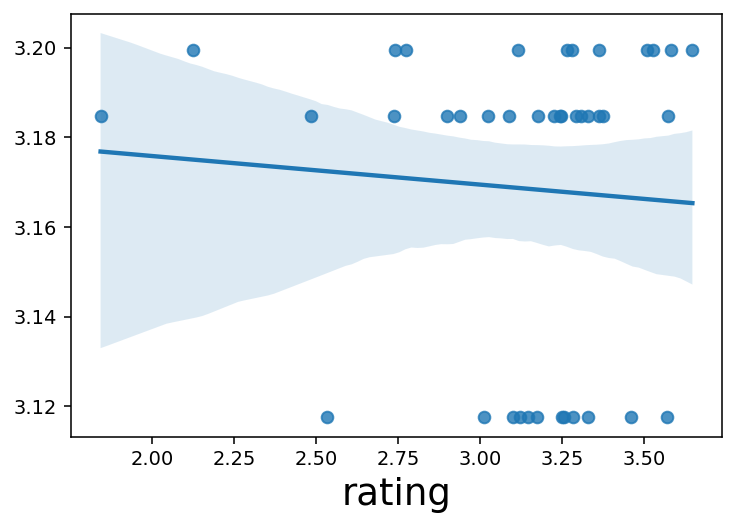

In [67]:
predictions = model.predict(X_test)
print(predictions)
ax3 = sns.regplot(x=y_test,y=predictions)

In [68]:
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls_brussels=sm.OLS(y_train,X_train_Sm).fit()
print(ls_brussels.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.3323
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.719
Time:                        22:25:13   Log-Likelihood:                -21.150
No. Observations:                  60   AIC:                             48.30
Df Residuals:                      57   BIC:                             54.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1994      0.098     32.663      0.0

Text(0, 0.5, 'Mean brewery rating')

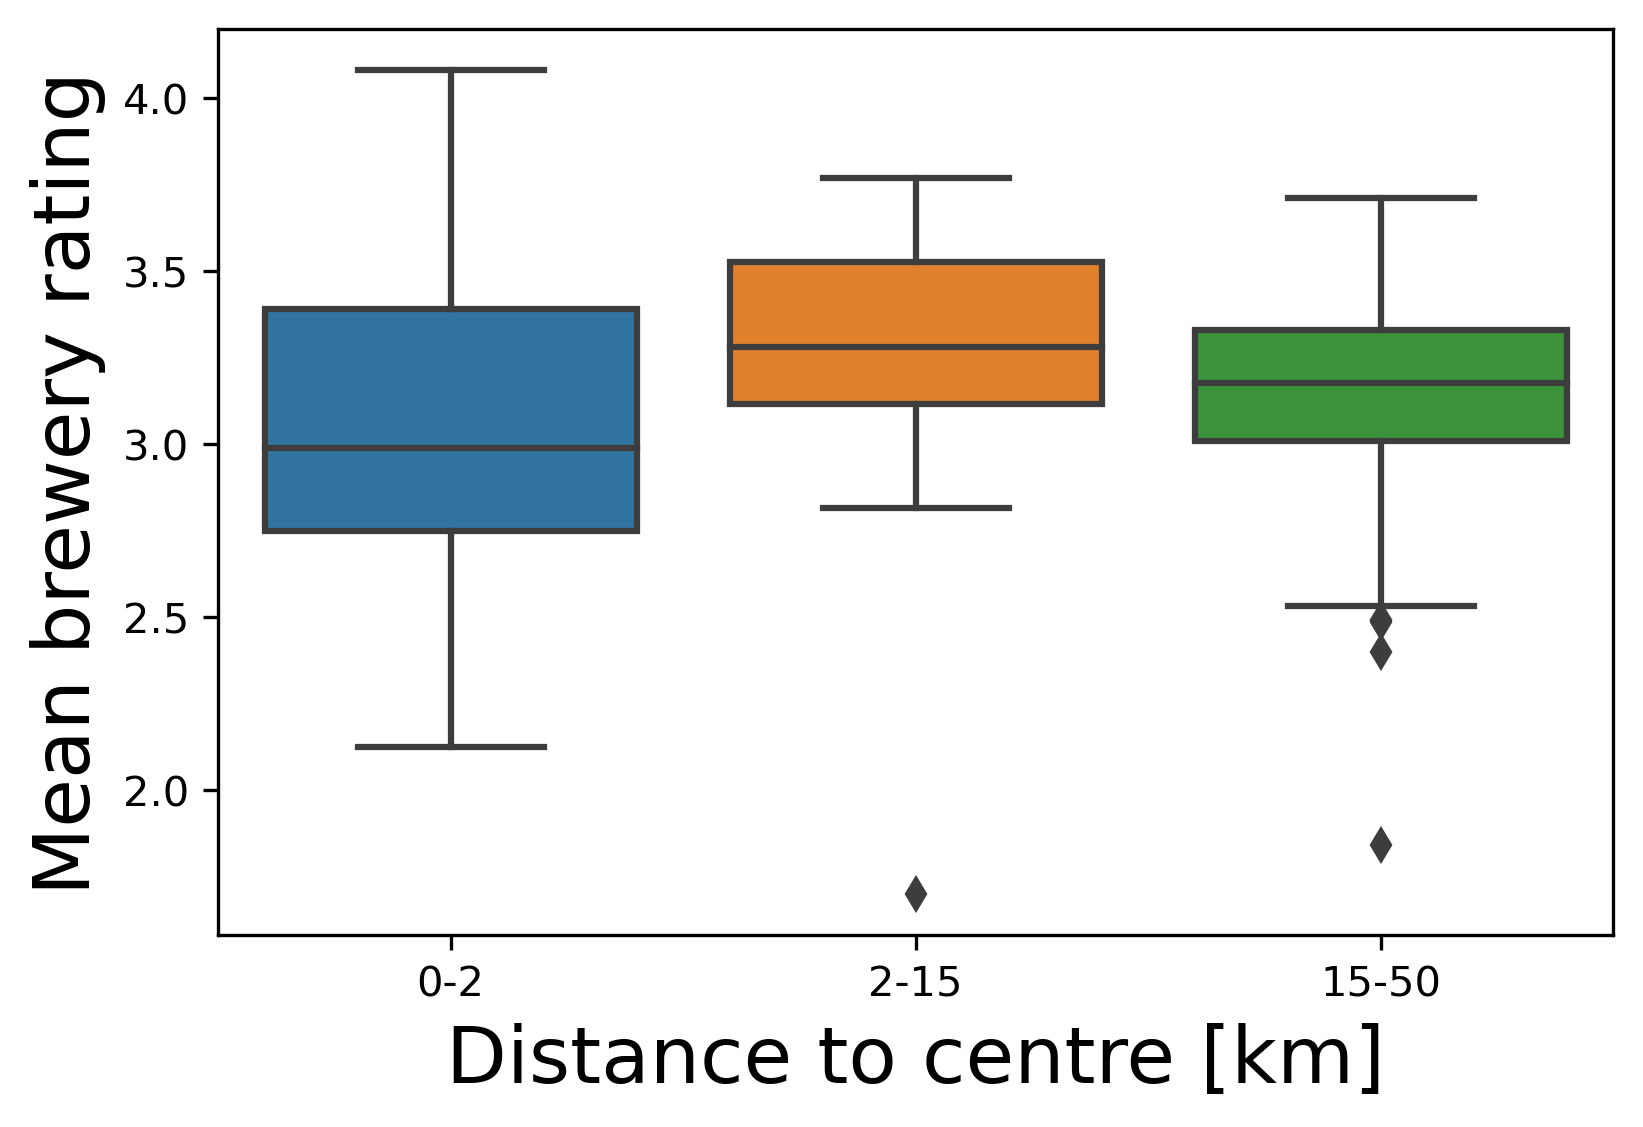

In [69]:
plt.rcParams['figure.dpi'] = 300
sns.boxplot(y='rating',x='cut_art',data=merged_bru)
plt.xlabel('Distance to centre [km]')
plt.ylabel('Mean brewery rating')

In [70]:
merged_bru[merged_bru['cut_art']=='0-2']['dist_km']

9648    1.571095
9809    1.339142
9813    1.949359
9878    0.287884
9915    1.808216
9924    0.071702
Name: dist_km, dtype: float64

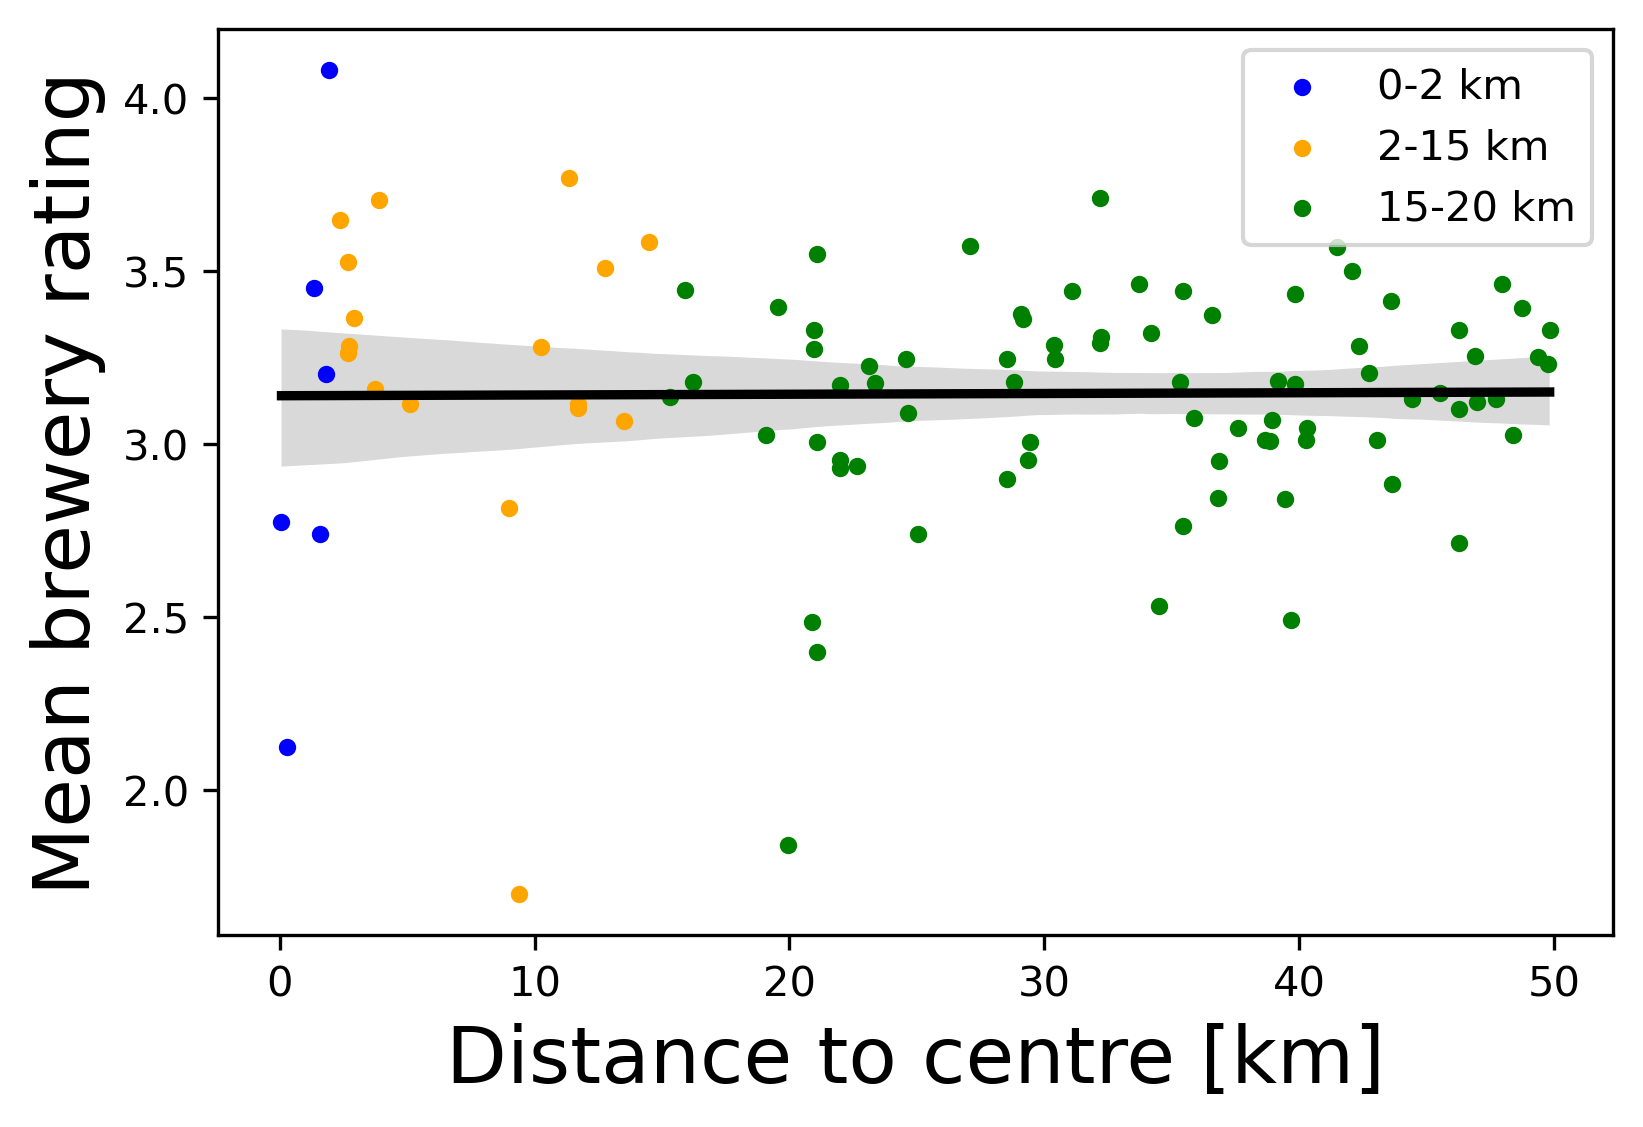

In [71]:
plt.figure()
sns.regplot(x = merged_bru['dist_km'], y=merged_bru['rating'], data=merged_bru, color = 'black', scatter_kws={'s':1},label='_Hidden label')
plt.scatter(merged_bru[merged_bru['cut_art']=='0-2']['dist_km'], merged_bru[merged_bru['cut_art']=='0-2']['rating'], 
            color ='blue', s=10, label='0-2 km')
plt.scatter(merged_bru[merged_bru['cut_art']=='2-15']['dist_km'], merged_bru[merged_bru['cut_art']=='2-15']['rating'], 
            color ='orange', s=10,  label='2-15 km')
plt.scatter(merged_bru[merged_bru['cut_art']=='15-50']['dist_km'], merged_bru[merged_bru['cut_art']=='15-50']['rating'], 
            color ='green', s=10,  label='15-20 km')
plt.xlabel('Distance to centre [km]')
plt.ylabel('Mean brewery rating')
plt.legend()

(60, 1)
(40, 1)
(60, 1)
(40, 1)
[3.22452304]
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5984
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.442
Time:                        22:25:14   Log-Likelihood:                -21.189
No. Observations:                  60   AIC:                             46.38
Df Residuals:                      58   BIC:                             50.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

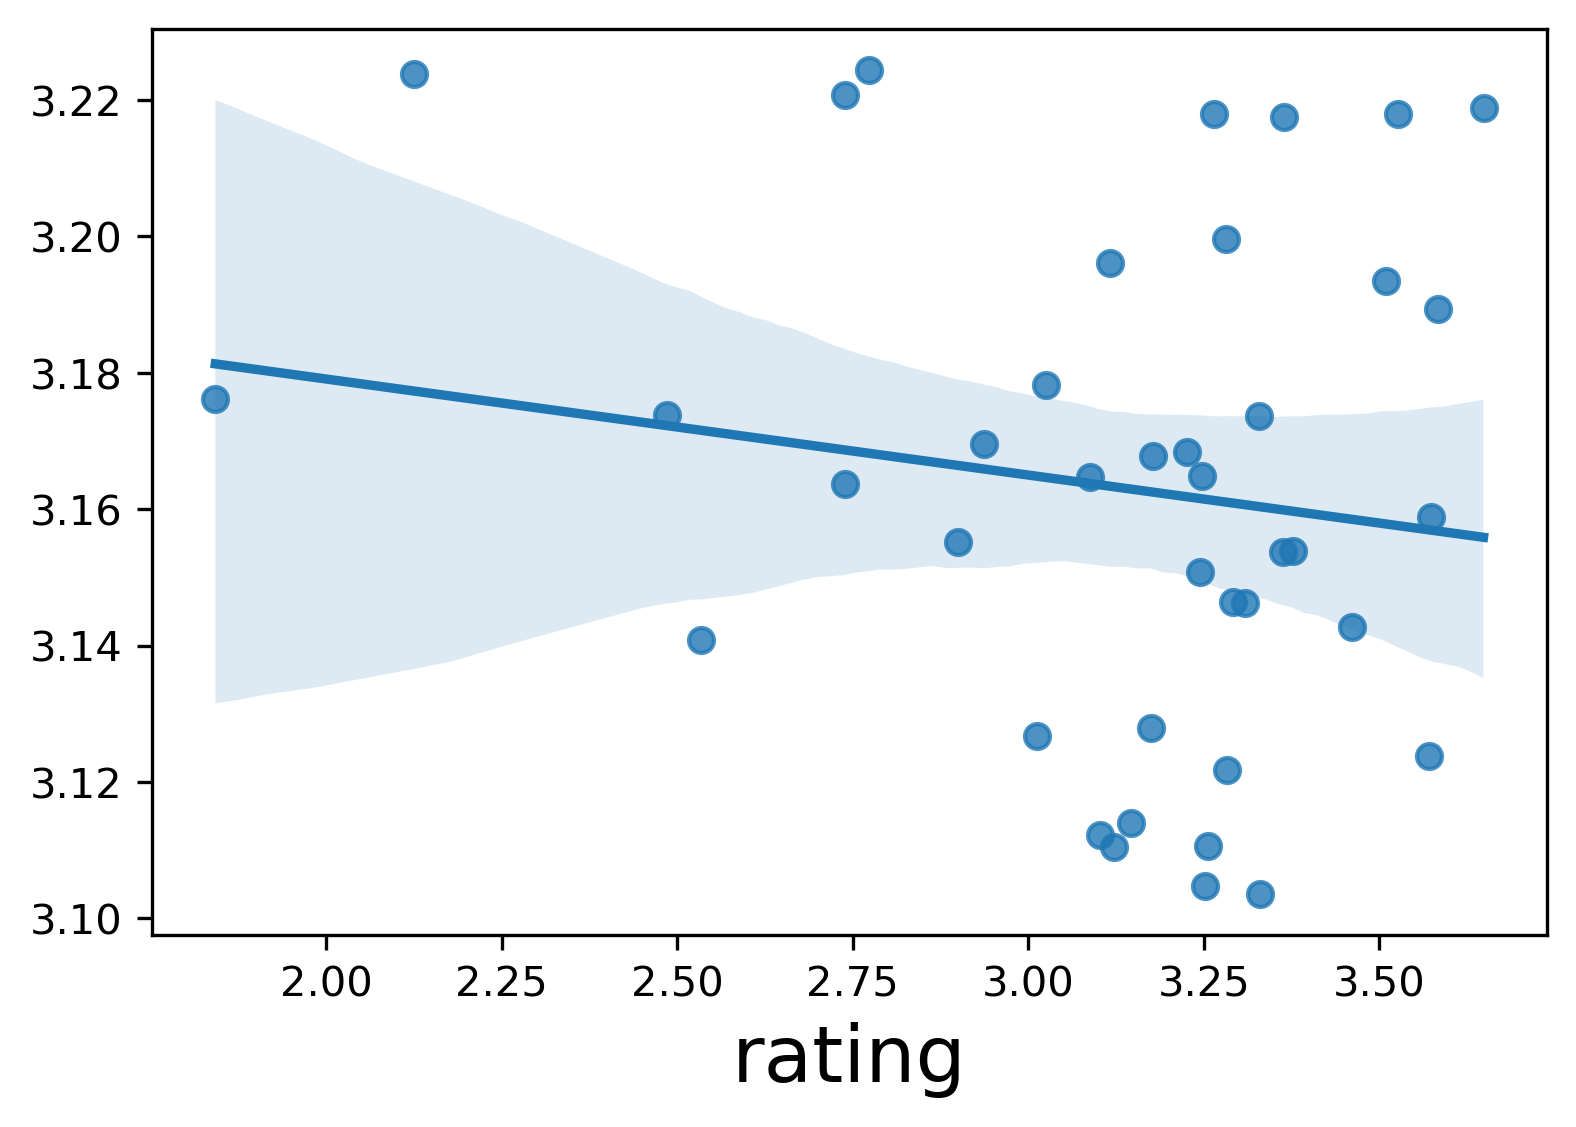

In [72]:
#Creating and training a model for linear regression over small breweries around Brussels
X = pd.DataFrame(merged_bru['dist_km'])
y = pd.DataFrame(merged_bru['rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train,y_train)
# print the intercept
print(model.intercept_)
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

predictions = model.predict(X_test)
ax3 = sns.regplot(x = y_test, y = predictions)

X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls_scatter_bru=sm.OLS(y_train,X_train_Sm).fit()
print(ls_scatter_bru.summary())